In [18]:
from helpers import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_percentage_error

sns.set_theme()

In [19]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])
df_tea = df.loc[df['Product']=='Tea',['Date','Quantity']].reset_index(drop=True)
del df

split_date = '2023-05-31'

df_train = df_tea[df_tea['Date']<=split_date].copy()

In [20]:
scaler_t = StandardScaler()

df_tea_log_scaled = df_train.copy()

df_tea_log_scaled['Quantity_log_Transform']= np.log(df_tea_log_scaled['Quantity'])
df_tea_log_scaled['Quantity_log_Scaled'] = scaler_t.fit_transform(df_tea_log_scaled[['Quantity_log_Transform']])
df_tea_log_scaled['Difference'] = df_tea_log_scaled['Quantity_log_Scaled'].diff()

In [21]:
idx = 8

model_df = df_tea_log_scaled.copy()
time_lag(model_df,'Difference',steps=idx)
model_df = model_df.dropna()

target = model_df['Difference']

f = []
for i in range(1,idx+1):
    f.append(f't-{i}')

features = model_df[f]

features = sm.add_constant(features)

log_scaled_mlr_model = sm.OLS(target,features).fit()

log_scaled_mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     10.81
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           1.20e-11
Time:                        00:35:59   Log-Likelihood:                -92.960
No. Observations:                 142   AIC:                             203.9
Df Residuals:                     133   BIC:                             230.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0649      0.041      1.565      0.120      -0.017       0.147
t-1           -0.6459      0.086     -7.495      0.000      -0.816      -0.475
t-2           -0.4470      0.101     -4.406      0.000      -0.648      -0.246
t-3           -0.2665      0.106     -2.503      0.014      -0.477      -0.056
t-4           -0.5541      0.105     -5.295      0.000      -0.761      -0.347
t-5           -0.4122      0.105     -3.929      0.000      -0.620      -0.205
t-6           -0.2933      0.108     -2.710      0.008      -0.507      -0.079
t-7           -0.1928      0.104     -1.853      0.066      -0.398       0.013
t-8           -0.1134      0.088     -1.294      0.198      -0.287       0.060
==============================================================================
Omnibus:                        2.041   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                1.611
Skew:                          -0.240   Prob(JB):                        0.447
Kurtosis:                       3.203   Cond. No.                         4.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

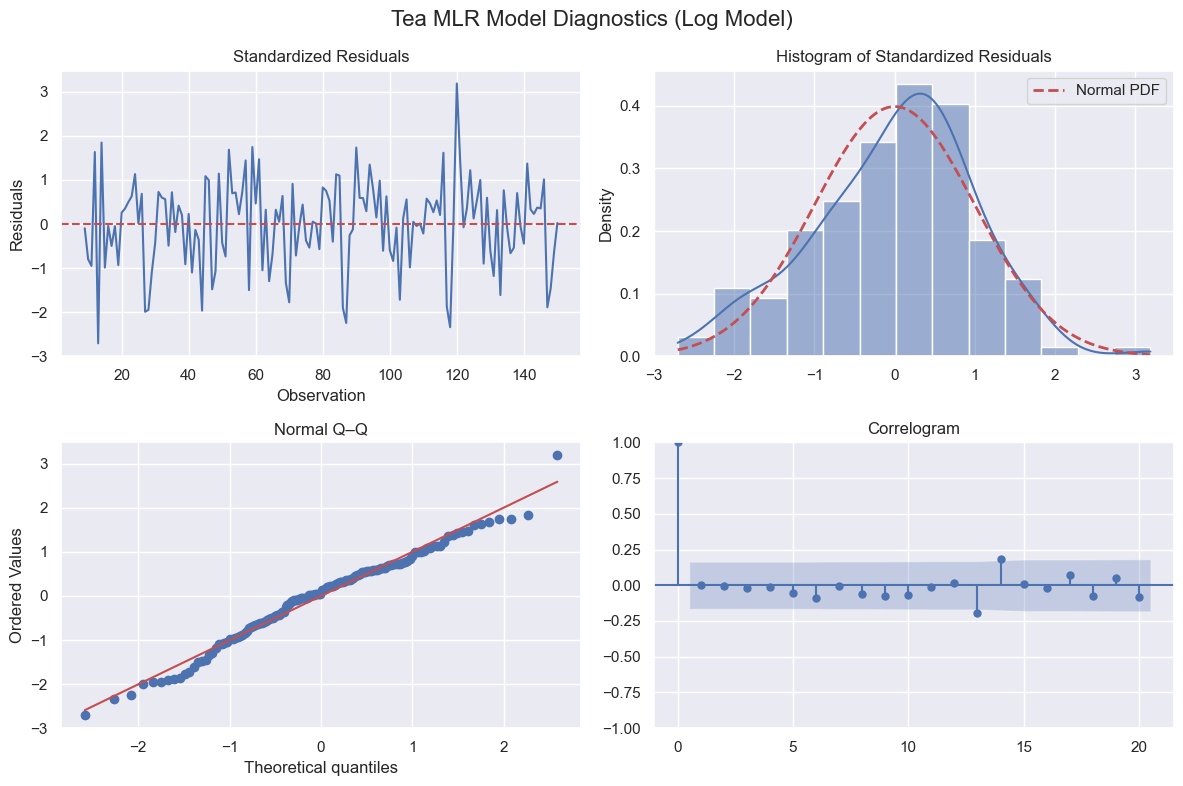

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Tea MLR Model Diagnostics (Log Model)", fontsize=16)

residuals = log_scaled_mlr_model.resid
resid_std = (residuals - residuals.mean()) / residuals.std()

#Residuals
axes[0, 0].plot(resid_std, linestyle='-')
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title("Standardized Residuals")
axes[0, 0].set_xlabel("Observation")
axes[0, 0].set_ylabel("Residuals")

#Histogram
sns.histplot(resid_std, kde=True, stat="density", ax=axes[0, 1])

x = np.linspace(resid_std.min(), resid_std.max(), 200)
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r--', linewidth=2, label="Normal PDF")
axes[0, 1].legend()
axes[0, 1].set_title("Histogram of Standardized Residuals")

#Q–Q plot
stats.probplot(resid_std, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Normal Q–Q")

#ACF plot
plot_acf(resid_std, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("Correlogram")

plt.tight_layout()

plt.savefig('Images/Diagnostics/Log_Tea_MLR_Model_Diagnostics.png')

plt.show()

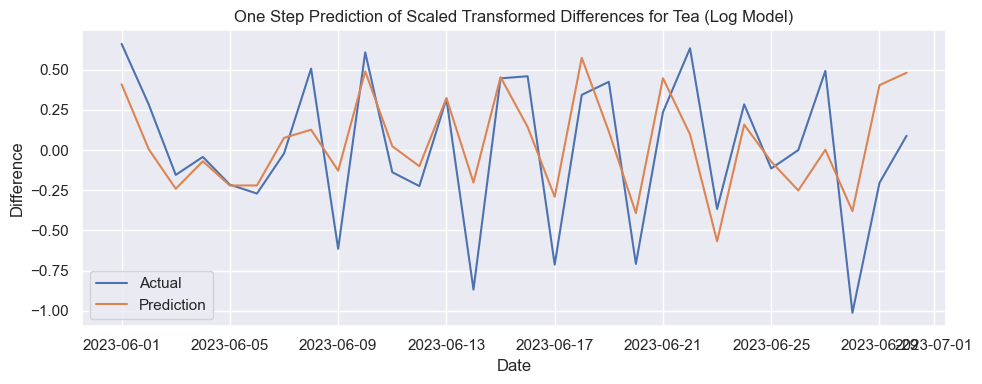

In [23]:
df_test = df_tea.iloc[df_tea.index[df_tea['Date'] == split_date][0]-idx:,].copy()
df_test['Quantity_log_Transform'] = np.log(df_test['Quantity'])
df_test['Quantity_log_Scaled'] = scaler_t.transform(df_test[['Quantity_log_Transform']])
df_test['Difference'] = df_test['Quantity_log_Scaled'].diff()

time_lag(df_test,'Difference',steps=idx)

df_test = df_test.dropna()

predictors = df_test.filter(like='t-')

predictors = sm.add_constant(predictors)

df_test['pred'] = log_scaled_mlr_model.predict(predictors)

plt.figure(figsize=(10,4))

ax= sns.lineplot(data=df_test, x='Date', y='Difference',label = 'Actual')
ax = sns.lineplot(data=df_test, x='Date', y='pred', label = 'Prediction')
ax.set(title = "One Step Prediction of Scaled Transformed Differences for Tea (Log Model)")

plt.tight_layout()
plt.savefig('Images/Forecasts/Log_Tea_Single_Step_Differenced.png')

plt.show()

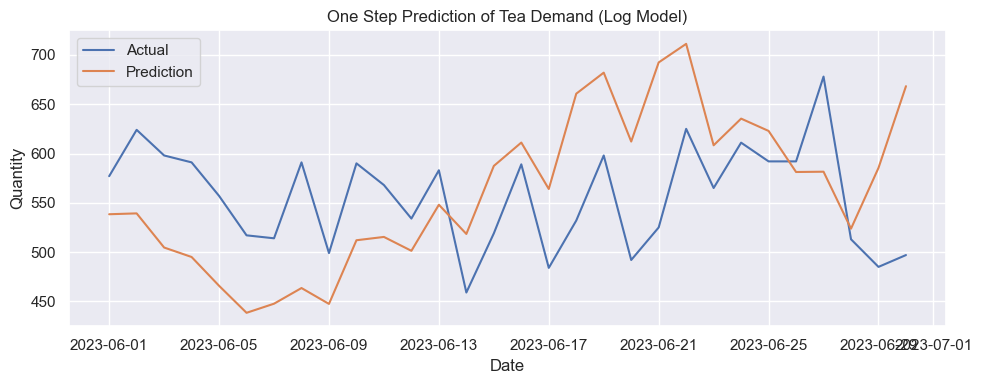

In [24]:
last_value = df_tea_log_scaled['Quantity_log_Scaled'][150]

df_test_rollup = df_test[['Date', 'Quantity','Quantity_log_Scaled','Difference','pred']].copy()

#add the differences starting with the last scaled transformed value (5-31-23) -> df_coffee_bc_scaled['Quantity_BC_Scaled'][150]
df_test_rollup['pred_undifferenced'] = df_test_rollup['pred'].cumsum() + last_value

#undo scaling
df_test_rollup['Undifferenced Unscaled'] = scaler_t.inverse_transform(df_test_rollup[['pred_undifferenced']])

#undo Box-Cox transform
df_test_rollup['Predicted Quantity'] = np.exp(df_test_rollup['Undifferenced Unscaled'])
df_test_rollup = df_test_rollup[['Date','Quantity','Predicted Quantity']]

plt.figure(figsize=(10,4))

ax= sns.lineplot(data=df_test_rollup, x='Date', y='Quantity',label ="Actual")
ax = sns.lineplot(data=df_test_rollup, x='Date', y='Predicted Quantity', label = 'Prediction')
ax.set(title = "One Step Prediction of Tea Demand (Log Model)")

plt.tight_layout()
plt.savefig('Images/Forecasts/Log_Tea_Single_Step_Rollup.png')

plt.show()

In [25]:
mape = mean_absolute_percentage_error(df_test_rollup['Quantity'],df_test_rollup['Predicted Quantity'])*100

print(f'One Step Quantity MAPE: {mape:.2f}%')

One Step Quantity MAPE: 13.60%


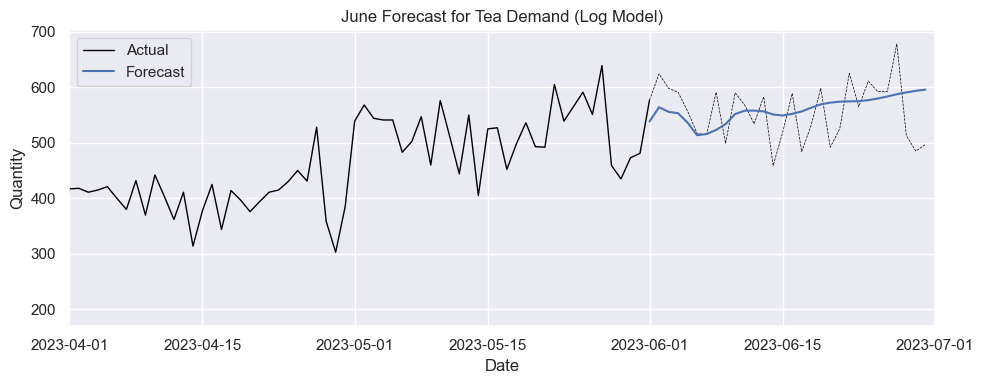

In [26]:
test_dates = pd.date_range('2023-06-01', '2023-06-30', freq='D')

latest_lags = list(df_test.iloc[0][['t-1','t-2','t-3','t-4','t-5','t-6','t-7','t-8']])

lags = [f't-{i}' for i in range(1, 9)]

forecast_diffs = []

for _ in range(len(test_dates)):
    X_new = pd.DataFrame([latest_lags], columns=lags)
    X_new = sm.add_constant(X_new, has_constant='add')
    
    y_pred = log_scaled_mlr_model.predict(X_new)[0]
    forecast_diffs.append(y_pred)
    
    # Update lag list for next day (push new prediction, drop oldest)
    latest_lags = [y_pred] + latest_lags[:-1]

df_forecast = pd.DataFrame({
    'Date': test_dates,
    'Predicted_Difference': forecast_diffs
})


df_forecast['Re-Summed'] = df_forecast['Predicted_Difference'].cumsum() + last_value

df_forecast['Unscaled'] = scaler_t.inverse_transform(df_forecast[['Re-Summed']])

df_forecast['Predicted Quantity'] = np.exp(df_forecast['Unscaled'])

plt.figure(figsize=(10,4))


ax = sns.lineplot(data=df_tea[df_tea['Date']<= '2023-06-01'], x='Date',y='Quantity',c='black', label = 'Actual',linewidth = 1)
ax = sns.lineplot(data=df_tea[df_tea['Date'] >= '2023-06-01'], x='Date',y='Quantity',c='black',linewidth = 0.5, linestyle = '--')
ax = sns.lineplot(data=df_forecast, x='Date',y='Predicted Quantity',label='Forecast')

ax.set(title = "June Forecast for Tea Demand (Log Model)")
plt.xlim(np.datetime64('2023-04-01'),np.datetime64('2023-07-01'))

plt.tight_layout()
plt.savefig('Images/Forecasts/Log_Tea_June_Forecast.png')

plt.show()

In [27]:
forecast_mape = mean_absolute_percentage_error(df_test_rollup['Quantity'],df_forecast['Predicted Quantity'])*100

print(f'Final Forecast MAPE: {forecast_mape:.2f}%')

Final Forecast MAPE: 8.11%


### July Forecast

In [28]:
tea_july_forecast = forecast_demand(df_tea, '2023-07-01','2023-07-31',idx = 8, style = 'log')

tea_july_forecast.to_csv('Results/log_tea_july_forecast.csv',index=False)

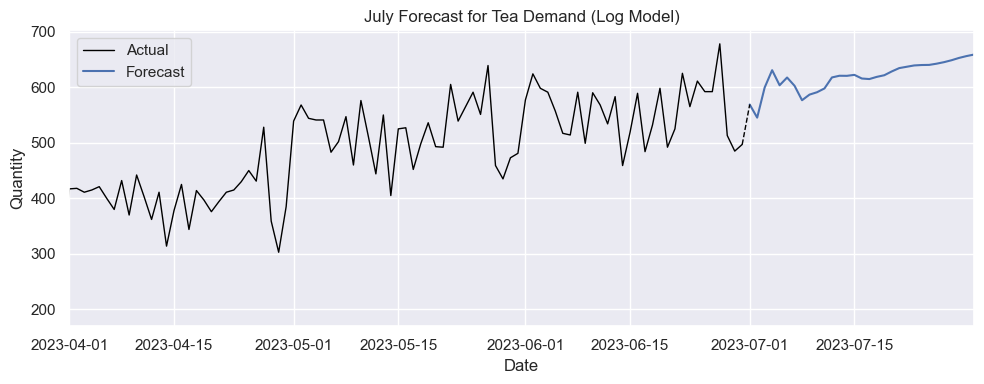

In [29]:
plt.figure(figsize=(10,4))

bridge_df = pd.DataFrame({'Date':[np.datetime64('2023-06-30'),np.datetime64('2023-07-01')],
                          'Quant':[df_tea['Quantity'][max(df_tea.index)],tea_july_forecast['Predicted Quantity'][0]]})

ax = sns.lineplot(data=df_tea, x='Date',y='Quantity',c='black', label = 'Actual',linewidth = 1)
ax = sns.lineplot(data=tea_july_forecast, x='Date',y='Predicted Quantity',label='Forecast')
ax = sns.lineplot(data=bridge_df, x='Date',y='Quant', c='Black', linestyle = '--', linewidth =1)

ax.set(title = "July Forecast for Tea Demand (Log Model)")
plt.xlim(np.datetime64('2023-04-01'),np.datetime64('2023-07-31'))

plt.tight_layout()
plt.savefig('Images/Forecasts/Log_Tea_July_Forecast.png')

plt.show()